In [1]:
import os
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy, kurtosis, skew

In [2]:

def favor_centrality(G, tol=0.0001):

    if len(G) == 0:
        raise nx.NetworkXPointlessConcept('cannot compute centrality for the null graph')
        
    g = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()

    supported_friends = (g.dot(g) > tol) & (g > tol)

    favor_centrality_list =  supported_friends.sum(axis=1)

    return dict(zip(G, favor_centrality_list)) 
    
def godfhater_index(G, tol=1.0e-10):

    if len(G) == 0:
        raise nx.NetworkXPointlessConcept('cannot compute centrality for the null graph')
        
    
    g = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
    
    godfhater_index_list = []
    for index, node in enumerate(G.nodes):
        prod = np.tensordot(g[:,index],g[:,index], axes = 0)
        prod_k_bigger_than_j = np.tril(prod,k=-1)
        
        prod_k_bigger_than_j = prod_k_bigger_than_j[(g.T < tol) & (g < tol)]

        gf_i = prod_k_bigger_than_j.sum()

        godfhater_index_list.append(gf_i)


    return dict(zip(G, godfhater_index_list))



In [3]:
try:
    output_filepath
except:
    output_filepath = '../data/processed/'

In [4]:
def compute_info(tol, year = '2015', graph = 'A_country.graphml', centrality = 'favor', statistical_information = 'entropy'):
    network_path = os.path.join(output_filepath, year, graph)
    G = nx.readwrite.graphml.read_graphml(network_path)

    if centrality == 'gfi':
        cent_dict  = godfhater_index(G,tol=tol)

    elif centrality == 'favor':
        cent_dict  = favor_centrality(G,tol=tol)
        
    values = np.array(list(cent_dict.values())).astype(float)
    
    #sns.distplot(values)

    if statistical_information == 'std':
        values -= values.mean() 
        return np.std(values)

    elif statistical_information == 'entropy':
        values = (values - values.mean())/values.std()
        values -= values.min()
        return entropy(values)

    elif statistical_information == 'kurtosis':
        values = (values - values.mean())/values.std()
        values -= values.min()
        return kurtosis(values)

    elif statistical_information == 'skew':
        values = (values - values.mean())/values.std()
        values -= values.min()
        return skew(values)

compute_info(tol=0.001, graph = 'A_country.graphml', centrality = 'favor')

4.083806708005329

In [5]:
def get_data(n, statistical_information = 'std',**kwargs):

    tols =  np.logspace(-n,-n+8,9)
    stds = [[compute_info(tol, str(y), statistical_information = statistical_information, **kwargs) for tol in tols] for y in range(2005, 2016)]

    df = pd.DataFrame(np.array(stds).T, index=tols, columns = range(2005, 2016))
    df = df.stack().reset_index()
    df.columns = ['tol', 'year', 'std']

    return df

def plot_dinamic_range(n=9, **kwargs):
    
    net = 'Financial' if kwargs.get('graph') == 'A_country.graphml' else 'Migration'
    capital = 'coordination' if kwargs.get('centrality') == 'gfi' else 'favor'

    fig, (ax1, ax2)  = plt.subplots(2, 1, figsize = (9,6), sharex=True)

    sns.boxplot(x='tol', y='std', data=get_data( n = n, statistical_information = 'entropy', **kwargs), ax=ax1)
    ax1.set_xlabel('$\epsilon$')
    ax1.set_ylabel('Entropy')
    ax1.title.set_text(f"{net} {capital} capital dinamic range for different $\epsilon$")

    sns.boxplot(x='tol', y='std',  data=get_data( n = n, statistical_information = 'skew', **kwargs), ax=ax2)
    ax2.set_xlabel('$\epsilon$')
    ax2.set_ylabel('Skewness')
    ax2.title.set_text(f"{net} {capital} capital dinamic range for different $\epsilon$")
    ax2.axhline(ls='--')

    plt.show()

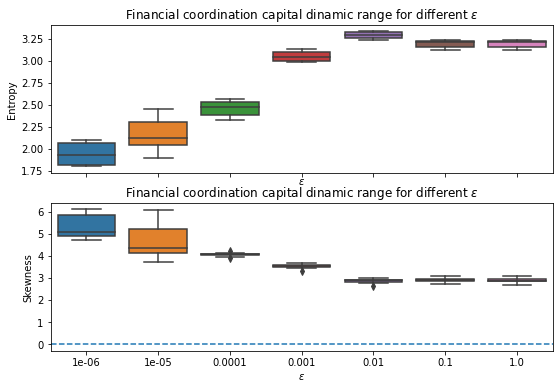

In [6]:
plot_dinamic_range(n=8, centrality='gfi', graph = 'A_country.graphml')

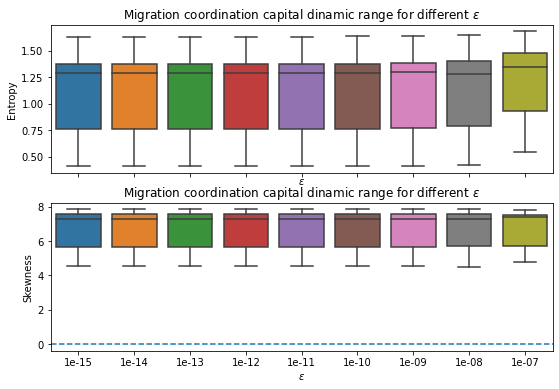

In [7]:
plot_dinamic_range(n=15, centrality='gfi', graph = 'migration_network.graphml')

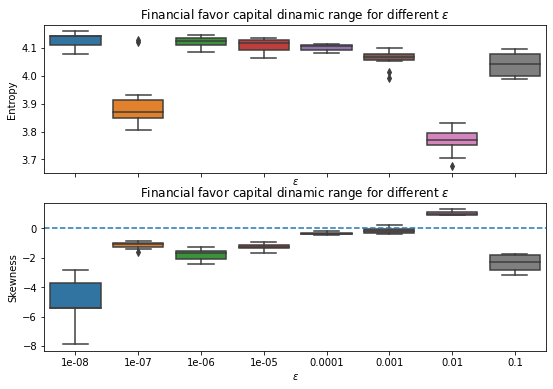

In [8]:
plot_dinamic_range(n=8, centrality='favor', graph = 'A_country.graphml')

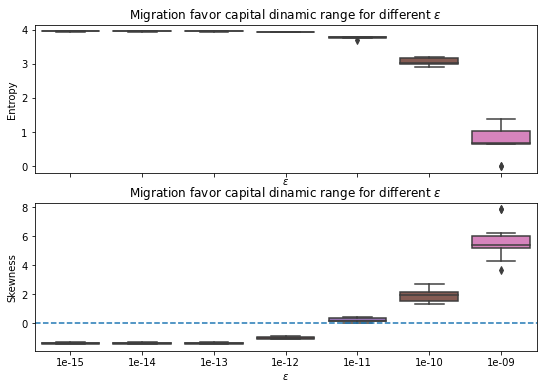

In [9]:
plot_dinamic_range(n=15, centrality='favor', graph = 'migration_network.graphml')